In [38]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

from liquidity.features import compute_aggregate_features, compute_impact_from_returns

from market_impact.fit import fit_scaling_law
from market_impact.util.utils import normalize_imbalances
from market_impact.response_functions import aggregate_impact
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.plot_utils import plot_propagator, plot_scaling_function, plot_collapsed_scaling_function

In [12]:
import priceprop.batch as pb

In [13]:

# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

### Load the data

In [14]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [15]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


### Generate true aggregate features with aggregate impact

In [16]:
aggregate_features = compute_aggregate_features(aapl_raw_df, [1])
imbalance_column = "sign_imbalance"
aggregate_impact_data = aggregate_impact(aggregate_features, conditional_variable=imbalance_column)
display(aggregate_impact_data)

,event_timestamp,Unnamed: 0,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,daily_vol,daily_num,norm_size,signed_volume,sign_imbalance,volume_imbalance,price_change_imbalance,T,price_change,R
0,2017-01-03 10:30:02.758712611,1,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,1398089,6170,0.200739,-153,-0.000162,-153,True,1,-0.010,-2.341556
1,2017-01-03 10:30:02.852790059,2,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1398089,6170,0.191380,200,0.000162,200,True,1,0.010,2.341556
2,2017-01-03 10:30:04.539218241,3,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1398089,6170,0.095690,100,0.000162,100,True,1,0.000,0.000000
3,2017-01-03 10:30:07.865732286,4,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1398089,6170,0.009569,10,0.000162,10,False,1,0.000,0.000000
4,2017-01-03 10:30:08.360855091,5,1,ASK,UPDATE,True,115.70,300,115.70,115.69,...,1398089,6170,0.287070,300,0.000162,300,False,1,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,6730,1,ASK,REMOVE,True,169.99,200,169.99,169.98,...,1452499,6735,0.258699,200,0.000148,200,True,1,0.005,0.163570
2633723,2017-12-29 14:59:26.825179397,6731,1,ASK,REMOVE,True,170.00,1200,170.00,169.98,...,1452499,6735,1.552195,1200,0.000148,1200,True,1,0.005,0.163570
2633724,2017-12-29 14:59:58.621436793,6732,-1,BID,UPDATE,True,169.99,300,170.00,169.99,...,1452499,6735,0.413298,-300,-0.000148,-300,False,1,0.000,0.000000
2633725,2017-12-29 14:59:58.621758027,6733,-1,BID,REMOVE,True,169.99,205,170.00,169.99,...,1452499,6735,0.282421,-205,-0.000148,-205,True,1,-0.010,-0.327140


In [12]:
# from market_impact.util.utils import normalize_impact, normalize_imbalances

In [13]:
# normalized_aggregate_features = normalize_impact(aggregate_features, normalization_column="R1")

In [14]:
# normalized_aggregate_features

In [17]:
MAX_NUM_SAMPLES = 1000000

### Generate propagator predictions
To compute conditional aggregate impact, we simulate the calibrated moded as a dynamic system, with the out-of-sample returns being used as input to compute the response functions from the predicted returns.

In [18]:
aggregate_impact_data["date"] = aggregate_impact_data["event_timestamp"].apply(lambda x: x.date())

trades = aggregate_impact_data[["event_timestamp","date", "R", "sign", "price_changing", "midprice", "daily_R1"]]
trades = trades.rename(columns={"R": "r1", "price_changing": "change"})
# trades['sample'] = trades["date"].apply(lambda x: x.day % 2)

In [19]:
db = {'tt': trades.head(MAX_NUM_SAMPLES)}

In [20]:
pb.calc_models(db, nfft='pad > 300', group=True, calibrate=True, split_by=None)

In [21]:
db['tt'].head(5)

,event_timestamp,date,r1,sign,change,midprice,daily_R1,sc,sn,r_cim,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
0,2017-01-03 10:30:02.758712611,2017-01-03,-2.341556,-1,True,115.695,0.004271,-1,0,-1.0,-0.960269,-1.713960,-1.669015,-1.713606
1,2017-01-03 10:30:02.852790059,2017-01-03,2.341556,1,True,115.685,0.004271,1,0,1.0,0.953595,1.790550,1.789258,1.786806
2,2017-01-03 10:30:04.539218241,2017-01-03,0.000000,1,True,115.695,0.004271,1,0,1.0,0.990436,1.824753,1.580097,1.827572
3,2017-01-03 10:30:07.865732286,2017-01-03,0.000000,1,False,115.695,0.004271,0,1,0.0,0.960957,-0.081887,-0.000000,-0.000000
4,2017-01-03 10:30:08.360855091,2017-01-03,0.000000,1,False,115.695,0.004271,0,1,0.0,0.944605,0.466138,0.000000,0.000000


In [22]:
hdim2_predictions = db['tt'][["event_timestamp", "r_hdim2_x2", "r1"]]

# choose returns to use further
hdim2_predictions["R1"] = hdim2_predictions["r_hdim2_x2"]

In [23]:
hdim2_predictions.head()

,event_timestamp,r_hdim2_x2,r1,R1
0,2017-01-03 10:30:02.758712611,-1.713606,-2.341556,-1.713606
1,2017-01-03 10:30:02.852790059,1.786806,2.341556,1.786806
2,2017-01-03 10:30:04.539218241,1.827572,0.000000,1.827572
3,2017-01-03 10:30:07.865732286,-0.000000,0.000000,-0.000000
4,2017-01-03 10:30:08.360855091,0.000000,0.000000,0.000000


In [2]:
# aggregate_features = compute_aggregate_features(aapl_raw_df, [1])
# aggregate_impact_data = aggregate_impact(aggregate_features, conditional_variable=imbalance_column)
# display(aggregate_impact_data)

In [3]:
# original_data = aggregate_impact_data.head(MAX_NUM_SAMPLES)

In [4]:
# all(hdim2_predictions["event_timestamp"] == original_data["event_timestamp"])

In [5]:
# model_aggregate_impact = original_data.copy()
# model_aggregate_impact["R"] = hdim2_predictions["r_hdim2_x2"]
# model_aggregate_impact.head()

In [6]:
# new_aggreagte_features = compute_aggregate_features(model_aggregate_impact, OBSERVATION_WINDOWS)

In [7]:
# new_aggreagte_features

In [8]:
# new_aggregate_impact = aggregate_impact(new_aggreagte_features, conditional_variable=imbalance_column)

In [9]:
# new_aggregate_impact

In [32]:
prop_aggregate_impact = compute_impact_from_returns(aapl_raw_df, hdim2_predictions, 
                               imbalance_column=imbalance_column, num_samples=MAX_NUM_SAMPLES)

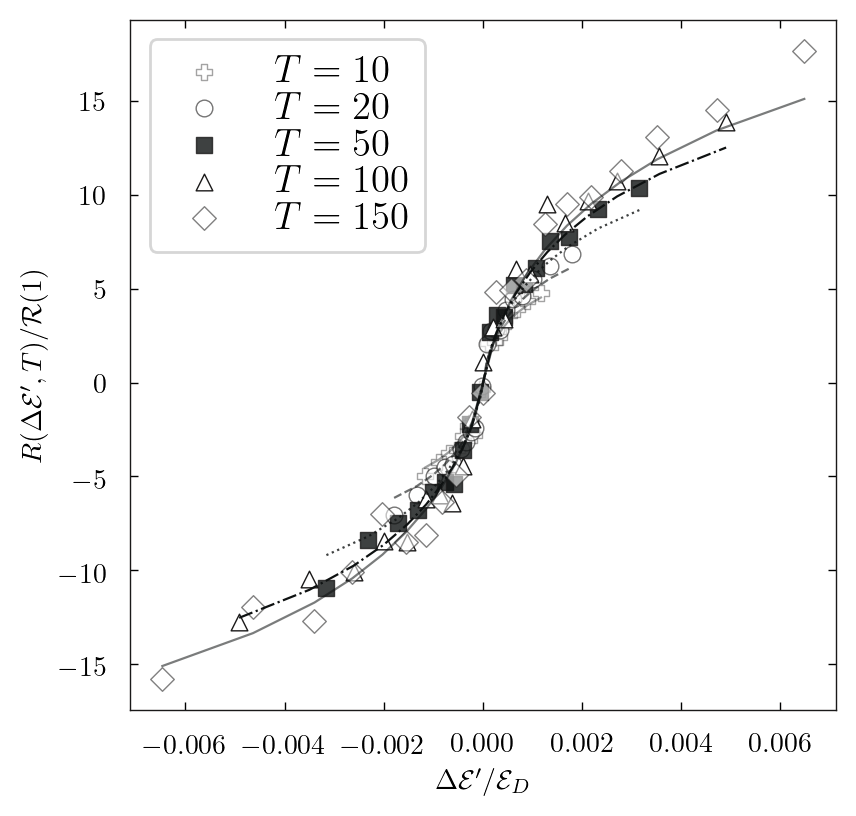

In [47]:
plot_scaling_function(prop_aggregate_impact, params=params, imbalance_column=imbalance_column, scaling_func=True)

In [33]:
# Prepare the data for fitting
T_values = prop_aggregate_impact['T'].values
imbalance_values = prop_aggregate_impact[imbalance_column].values
R_values = prop_aggregate_impact['R'].values

# Fit data for all Ts
params = fit_scaling_law(T_values, imbalance_values, R_values, reflect_y=False)

In [34]:
# Retrieve initial optimized parameters
chi, kappa, alpha, beta, CONST = params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.4507877270350961
kappa: 0.6500063752572595
alpha: 0.2692453007310336
beta: 6.772736597633678
CONST: 81862.2841373073


### Transform data
To do the fss by method of least-squares, we use optimized critical paramters to rescale the scaling function onto a single master curve by initially fitting the scaling law to all $T$.

In [42]:
# Transform original data using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_data = transform(prop_aggregate_impact, rescaling_params=params, imbalance_column=imbalance_column)

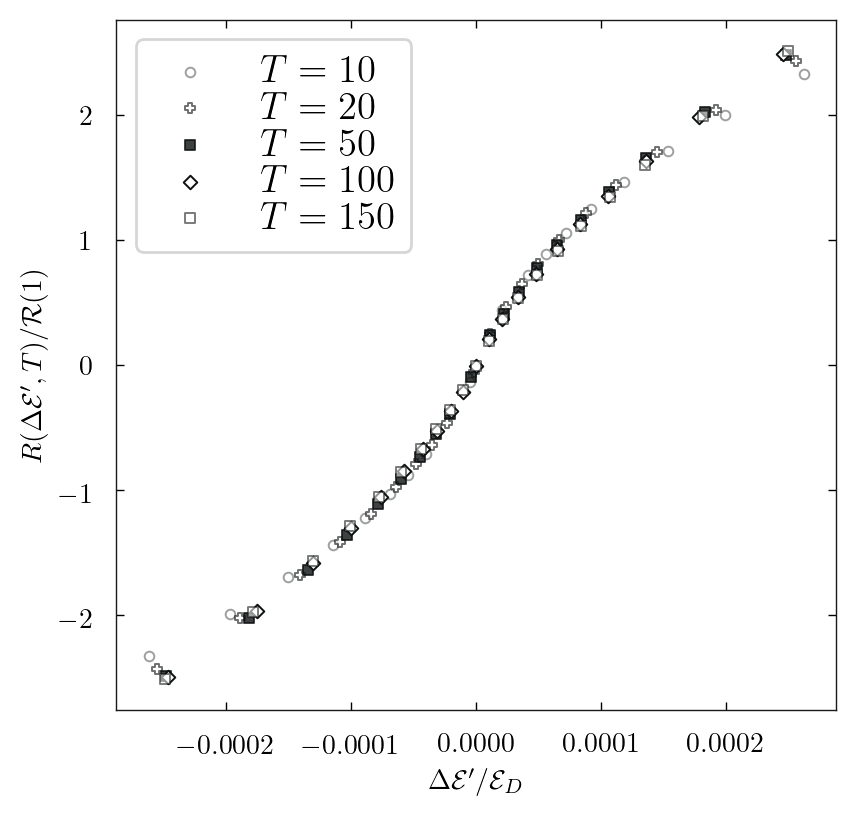

In [46]:
plot_propagator(rescaled_data, params=params, imbalance_column=imbalance_column)

In [111]:
# Transform original shape parameters 𝛼 and 𝛽 using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_params, rescaled_data = transform(new_aggregate_impact, original_params=params, imbalance_column=imbalance_column)

# Retrieve rescaled parameters
chi, kappa, alpha, beta, CONST = rescaled_params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.21501694404816957
kappa: 0.20408256907884292
alpha: 84.7445847382665
beta: 4.559599704202667
CONST: 7213.993572624896
